In [7]:
import jax
import jax.nn
import numpy as np
import numpyro
import optax
from numpyro.handlers import block, trace, seed
from jax import random, vmap
import matplotlib.pyplot as plt

In [1]:
%load_ext autoreload
%autoreload 2

from experiments.src.experiment import *
from experiments.src.data import *
from experiments.src.model import BNNRegressor

In [9]:
# %matplotlib inline
# import matplotlib
# matplotlib.use("nbAgg")  # noqa: E402

plt.rcParams.update({
    "axes.grid": True,  # show grid by default
    "font.weight": "bold",  # bold fonts
    "xtick.labelsize": 15,  # large tick labels
    "ytick.labelsize": 15,  # large tick labels
    "lines.linewidth": 1,  # thick lines
    "lines.color": "k",  # black lines
    # "grid.color": "0.5",    # gray gridlines
    "grid.linestyle": "-",  # solid gridlines
    "grid.linewidth": 0.1,  # thin gridlines
    "savefig.dpi": 300,  # higher resolution output.
})

In [35]:
DEVICE = "cpu"
numpyro.set_platform(DEVICE)
# numpyro.set_host_device_count(NUM_CHAINS)
BNN_SIZE = [20]

In [2]:
class NalisnickBNNMisspecData(Data):
    def __init__(self, training_size, test_size):
        np.random.seed(0)
        X = np.random.uniform(-1, 1, size=training_size)
        Y = np.random.laplace(scale=np.sqrt(0.05), size=(training_size, 1))
        mask = np.random.choice([0, 1], size=(training_size, 1))
        X = jnp.where(mask.squeeze(), X, 0.)
        Y = jnp.where(mask, Y, 0.)
        X = self._feature_expand(X)
        self._X, self._Y = X, Y

        self._X_test = self._feature_expand(jnp.linspace(-1, 1, test_size))

    def _feature_expand(self, X: jax.Array):
        return jnp.power(X[:, np.newaxis], jnp.arange(50))  # XXX ?bias included in model

    @property
    def train(self) -> tuple[jax.Array, jax.Array]:
        return self._X, self._Y

    @property
    def test(self) -> tuple[jax.Array, Optional[jax.Array]]:
        return self._X_test, None

    def true_predictive(self, X: jax.Array) -> dist.Distribution:
        raise NotImplementedError()

In [3]:
data = NalisnickBNNMisspecData(training_size=100, test_size=500)

In [63]:
bnn = BNNRegressor(
    nonlin=jax.nn.relu,
    D_X=50,
    D_Y=1,
    D_H=BNN_SIZE,
    biases=True,
    obs_model=1 / 0.01**2,
    # prior_scale=2,
    # prior_type='xavier',
)
bnn.get_weight_dim()

1041

In [64]:
hmc = BasicHMCExperiment(bnn, data, num_warmup=500, num_samples=400, num_chains=1)

sample: 100%|██████████| 900/900 [01:06<00:00, 13.43it/s, 1023 steps of size 4.45e-03. acc. prob=0.83]



MCMC elapsed time: 69.29438495635986


<IPython.core.display.Javascript object>

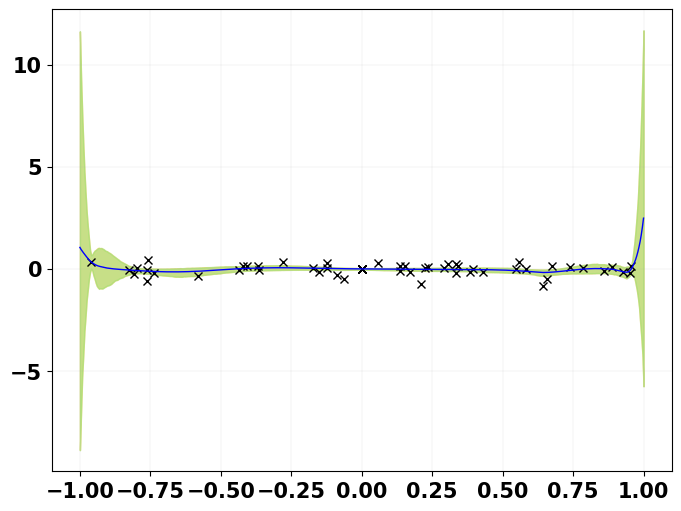

In [65]:
hmc.run(random.PRNGKey(0))

In [58]:
fig, ax = plt.subplots()

t = data.test[0][:, 1]

for i in range(5):
    mu =  hmc._predictions['Y_mean'][i, :, 0]
    sigma = hmc._predictions['sigma_obs'][i]
    ax.plot(t, mu)
    ax.fill_between(t, mu - sigma, mu  + sigma, alpha=0.05)

plt.show()

<IPython.core.display.Javascript object>

In [44]:
# For prior:
ndraws = 5
fig, ax = plt.subplots()

with seed(rng_seed=random.PRNGKey(1)):
    for _ in range(ndraws):
        prior_fn = trace(bnn).get_trace(X=data.test[0], Y=None)
        mu = prior_fn['Y_mean']['value'].squeeze()
        sigma = prior_fn['sigma_obs']['value']
        ax.plot(t, mu)
        ax.fill_between(t, mu - sigma, mu  + sigma, alpha=0.05)

plt.show()

<IPython.core.display.Javascript object>

In [82]:
vi = BasicMeanFieldGaussianVIExperiment(bnn, data, num_samples=400, max_iter=50_000, lr_schedule=optax.constant_schedule(-0.0005), num_particles=1, num_eval_particles=16)

In [ ]:
vi.run(random.PRNGKey(0))

In [90]:
vi.make_predictions(random.PRNGKey(1))

In [91]:
fig, ax = plt.subplots()

for i in range(5):
    mu = vi._predictions['Y_mean'][i, :, 0]
    sigma = vi._predictions['Y_scale'][i, :, 0]
    ax.plot(t, mu)
    ax.fill_between(t, mu - sigma, mu + sigma, alpha=0.05)

plt.show()

<IPython.core.display.Javascript object>

In [92]:
laplace = AutoDiagonalLaplaceExperiment(bnn, data, shrink=1000, num_samples=400, num_particles=1)

In [98]:
laplace.make_predictions(random.PRNGKey(1))

In [99]:
fig, ax = plt.subplots()

for i in range(5):
    mu = laplace._predictions['Y_mean'][i, :, 0]
    sigma = laplace._predictions['Y_scale'][i, :, 0]
    ax.plot(t, mu)
    ax.fill_between(t, mu - sigma, mu + sigma, alpha=0.05)

plt.show()

<IPython.core.display.Javascript object>

Initial eval loss: 1036.1761 (lik: -539.0531, kl: 497.1230)


100%|██████████| 50/50 [00:19<00:00,  2.59it/s, init loss: 1036.1761, avg. train loss / eval. loss [147000-150000]: 266.1661 / 266.1346]


SVI elapsed time: 19.49991011619568


<IPython.core.display.Javascript object>

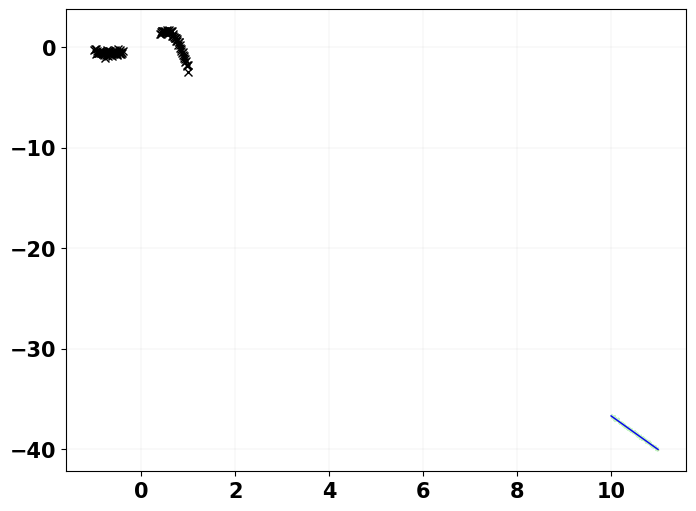

In [101]:
map = AutoDeltaVIExperiment(bnn, data, num_samples=1, num_particles=1, num_eval_particles=1)
map.run(random.PRNGKey(0))

In [102]:
swag = SWAGExperiment(bnn, data, map, rank=20, learning_rate=0.01, num_samples=400)

100%|██████████| 5000/5000 [00:09<00:00, 535.82it/s, init loss: 266.1346, avg. loss [4751-5000]: 287.5695]


<IPython.core.display.Javascript object>

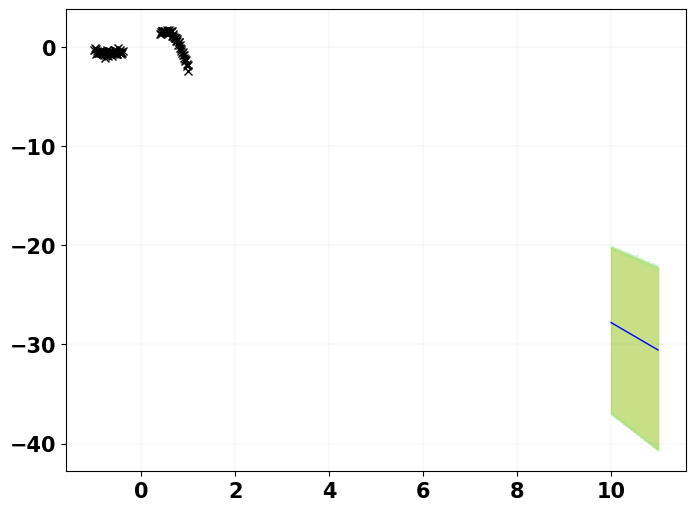

In [103]:
swag.run(random.PRNGKey(0))

In [104]:
fig, ax = plt.subplots()

for i in range(5):
    mu = laplace._predictions['Y_mean'][i, :, 0]
    sigma = laplace._predictions['Y_scale'][i, :, 0]
    ax.plot(t, mu)
    ax.fill_between(t, mu - sigma, mu + sigma, alpha=0.05)

plt.show()

<IPython.core.display.Javascript object>